<span style="font-family:Arial; font-weight:Bold; font-size:2.3em; color:#00b3e5;"> MiniBatchKMeans Clusterer
 - <span style="color:dodgerblue;"> **Pros:**
   - <span style="color:black;"> Fast 
 - <span style="color:deeppink;"> **Cons:**
   - <span style="color:black;">  

<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> Objective:
 - To cluster diabetes using MiniBatchKMeans Clusterer

<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> Loading Libraries

In [1]:
import time, pickle

import numpy  as np
from   numpy import mean, std

import pandas as pd
pd.set_option('display.max_rows',200)
pd.set_option('display.max_columns',None)

from matplotlib import pyplot as plt

import seaborn as sns
sns.set(style="ticks", color_codes=True)
from   seaborn import boxplot as BoxPlot

from imblearn.combine import SMOTETomek, SMOTEENN

from sklearn.cluster  import MiniBatchKMeans
from sklearn.metrics  import silhouette_score 

from sklearn.preprocessing import scale 
#from sklearn.preprocessing   import LabelEncoder 
#from sklearn.model_selection import train_test_split, StratifiedKFold, RepeatedStratifiedKFold, cross_val_score

#from sklearn.metrics         import accuracy_score, recall_score, precision_score

##### 
<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> Loading and Exploring the Data

In [2]:
# (input) importing Raw data

data_set_name    = 'Pima_Diabetes' 

data_file  = 'Pima_Diabetes.csv'
data_sheet = 'Pima_Diabetes'

# needed parameters 
RANDOM_STATE =  3 

# (auto)
df_raw = pd.read_csv( data_file, header=0 ) # , delimiter=','
print(f'there are {df_raw.shape[0]} rows and {df_raw.shape[1]} columns.')

df_raw.tail() 

there are 768 rows and 9 columns.


,Pregnancy,Blood_Plasma,Blood_Pressure,Skin,Test,Body_Mass_Index,Pedi,Age,Class
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1
767,1,93,70,31,0,30.4,0.315,23,0


#####   

##### 
<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> Observing Random Records

In [3]:
np.random.seed(3)
cm = sns.light_palette('#ffcccb', as_cmap=True)

df_raw.sample(n=200).style.\
    background_gradient(subset=['Class'], cmap=cm).\
    bar(subset=['Pregnancy','Test','Pedi'], color='deeppink').\
    bar(subset=['Blood_Plasma','Skin','Body_Mass_Index','Age'], color='cyan').\
    bar(subset=['Blood_Pressure'], color='deeppink').\
    highlight_null(color='lime').\
    format(precision=2).\
    hide(axis="index")       #.to_excel('styled.xlsx', engine='openpyxl')

Pregnancy,Blood_Plasma,Blood_Pressure,Skin,Test,Body_Mass_Index,Pedi,Age,Class
1,101,50,15,36,24.20,0.53,26,0
4,156,75,0,0,48.30,0.24,32,1
1,97,66,15,140,23.20,0.49,22,0
2,197,70,99,0,34.70,0.57,62,1
13,106,72,54,0,36.60,0.18,45,0
4,154,62,31,284,32.80,0.24,23,0
5,99,74,27,0,29.00,0.20,32,0
2,68,62,13,15,20.10,0.26,23,0
4,110,92,0,0,37.60,0.19,30,0
6,114,0,0,0,0.00,0.19,26,0


##### 
<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> Exploring The Data (Info & Describe)

In [4]:
print( df_raw.info() )
print('')
df_raw.describe().T.style.format(precision=1)   

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Pregnancy        768 non-null    int64  
 1   Blood_Plasma     768 non-null    int64  
 2   Blood_Pressure   768 non-null    int64  
 3   Skin             768 non-null    int64  
 4   Test             768 non-null    int64  
 5   Body_Mass_Index  768 non-null    float64
 6   Pedi             768 non-null    float64
 7   Age              768 non-null    int64  
 8   Class            768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB
None



,count,mean,std,min,25%,50%,75%,max
Pregnancy,768.0,3.8,3.4,0.0,1.0,3.0,6.0,17.0
Blood_Plasma,768.0,120.9,32.0,0.0,99.0,117.0,140.2,199.0
Blood_Pressure,768.0,69.1,19.4,0.0,62.0,72.0,80.0,122.0
Skin,768.0,20.5,16.0,0.0,0.0,23.0,32.0,99.0
Test,768.0,79.8,115.2,0.0,0.0,30.5,127.2,846.0
Body_Mass_Index,768.0,32.0,7.9,0.0,27.3,32.0,36.6,67.1
Pedi,768.0,0.5,0.3,0.1,0.2,0.4,0.6,2.4
Age,768.0,33.2,11.8,21.0,24.0,29.0,41.0,81.0
Class,768.0,0.3,0.5,0.0,0.0,0.0,1.0,1.0


#####   
<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:deeppink;"> Report:
 - No Empty Cells Found.
 - Features: 'Blood_Plasma', 'Blood_Pressure', 'Skin', 'Test', 'Body_Mass_Index' 
   - include 0 which is impossible, and means missing value
 - These 0s must be converted to np.nan

##### 
<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> Converting 0s to np.nan

In [5]:
Features_with_Missin_Values = ['Blood_Plasma', 'Blood_Pressure', 'Skin', 'Test', 'Body_Mass_Index']

df_missing = df_raw.copy()
for ft in Features_with_Missin_Values:
    df_missing[ft] = df_missing[ft].replace(0,np.nan)
    
df_missing.head(10).style.\
    highlight_null(color='lime').\
    format(precision=2).\
    hide(axis="index")       #.to_excel('styled.xlsx', engine='openpyxl')

Pregnancy,Blood_Plasma,Blood_Pressure,Skin,Test,Body_Mass_Index,Pedi,Age,Class
6,148.00,72.00,35.00,nan,33.60,0.63,50,1
1,85.00,66.00,29.00,nan,26.60,0.35,31,0
8,183.00,64.00,nan,nan,23.30,0.67,32,1
1,89.00,66.00,23.00,94.00,28.10,0.17,21,0
0,137.00,40.00,35.00,168.00,43.10,2.29,33,1
5,116.00,74.00,nan,nan,25.60,0.20,30,0
3,78.00,50.00,32.00,88.00,31.00,0.25,26,1
10,115.00,nan,nan,nan,35.30,0.13,29,0
2,197.00,70.00,45.00,543.00,30.50,0.16,53,1
8,125.00,96.00,nan,nan,nan,0.23,54,1


##### 
<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> Handling Missing Values by KNNImputer

In [6]:
from sklearn.impute import KNNImputer
imputer   = KNNImputer( n_neighbors=2, weights="distance" )   # 'distance', 'uniform'

# Features_with_Missin_Values = ['Blood_Plasma', 'Blood_Pressure', 'Skin', 'Test', 'Body_Mass_Index'] 
X_Null    = df_missing[ Features_with_Missin_Values ].values.copy()
X_Treated = imputer.fit_transform( X_Null )

In [7]:
df_Treated    = pd.DataFrame(X_Treated, columns=Features_with_Missin_Values)
#df.columns   = [ Features_with_Missin_Values ]
df_no_missing = df_missing.copy()
df_no_missing[ Features_with_Missin_Values ] = df_Treated.copy()
print(f'there are {df_no_missing.shape[0]} rows and {df_no_missing.shape[1]} columns.') 

df_no_missing.sample(n=200).style.\
    background_gradient(subset=['Class'], cmap=cm).\
    bar(subset=['Pregnancy','Test','Pedi'], color='deeppink').\
    bar(subset=['Blood_Plasma','Skin','Body_Mass_Index','Age'], color='cyan').\
    bar(subset=['Blood_Pressure'], color='deeppink').\
    highlight_null(color='lime').\
    format(precision=2).\
    hide(axis="index")       #.to_excel('styled.xlsx', engine='openpyxl')

there are 768 rows and 9 columns.


Pregnancy,Blood_Plasma,Blood_Pressure,Skin,Test,Body_Mass_Index,Pedi,Age,Class
5,168.00,64.00,36.32,205.82,32.90,0.14,41,1
4,114.00,64.00,18.32,143.04,28.90,0.13,24,0
6,115.00,60.00,39.00,108.12,33.70,0.24,40,1
2,112.00,68.00,22.00,94.00,34.10,0.32,26,0
2,90.00,70.00,17.00,64.99,27.30,0.09,22,0
4,122.00,68.00,28.60,271.80,35.00,0.39,29,0
8,99.00,84.00,25.00,108.73,35.40,0.39,50,0
6,114.00,73.00,35.00,242.50,38.50,0.19,26,0
2,175.00,88.00,30.44,226.70,22.90,0.33,22,0
3,193.00,70.00,31.00,301.25,34.90,0.24,25,1


#####   
<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:deeppink;"> Report:
 - In Features: 'Blood_Plasma', 'Blood_Pressure', 'Skin', 'Test', 'Body_Mass_Index' 
   - The 0s are replaced with appropriate values.

** **

##### 
<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> Detecting Outliers by Boxplots

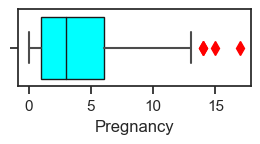

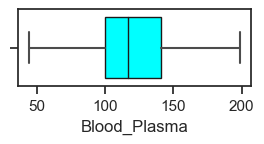

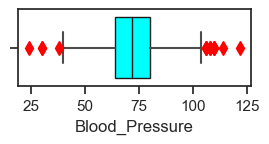

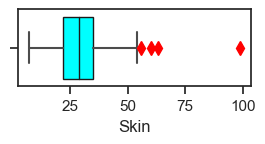

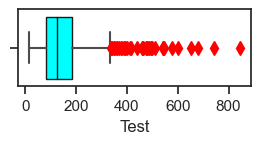

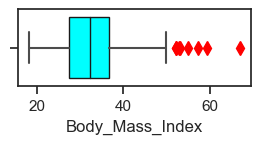

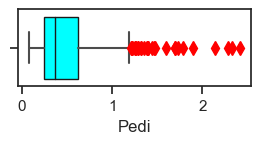

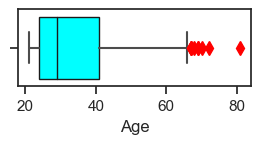

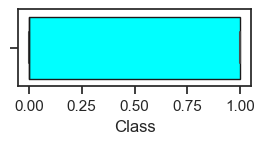

In [8]:
# (auto) 
df = df_no_missing.copy()

scalar_columns = []
for col in df.columns:
    if df[col].dtype!='object': scalar_columns.append( col )

boxprops    = dict( linewidth=1, edgecolor='k', facecolor='cyan' )
medianprops = dict( linewidth=1, color='k' )
flierprops  = dict( marker='d', markersize=7, markerfacecolor='red', markeredgecolor='red' )

for ft in scalar_columns:
    plt.figure(  figsize=(3,1)   )
    BoxPlot( x=df[ ft ] 
           , boxprops    = boxprops
           , medianprops = medianprops
           , flierprops  = flierprops  
           )
    plt.show()

#####   
<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:deeppink;"> Report: 
 - features: 'Pregnancy', 'Blood_Pressure', 'Skin', 'Test', 'Body_Mass_Index', 'Pedi', 'Age'
   - have outliers and need treatment

** **

#####   
<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> Treating Outliers

<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:#00b3e5;"> Treating Outliers by Winsorizing

In [9]:
# Winsorizing Extreme Outliers
df_dirty = df_no_missing.copy()    
columns_with_outliers = [ 'Pregnancy', 'Blood_Pressure', 'Skin', 'Test', 'Body_Mass_Index', 'Pedi', 'Age' ]

def winsorize_by_zscore(df,ft):
    x  = df[ft].copy()
    M  = x.mean()
    SD = x.std()
    z  = (x-M) / SD
    
    upper_bound = +3
    lower_bound = -3
    
    ls = df.index[ (z > upper_bound) 
                 | (z < lower_bound) ]
    
    x_Des=sorted(x,reverse=True)
    i=0
    while x_Des[i] >=  M + 3*SD:
        i=i+1 
    MAX=x_Des[i] 
    
    x_Asc=sorted(x,reverse=False)
    i=0 
    while x_Asc[i] <=  M - 3*SD:
        i=i+1  
    MIN=x_Asc[i] 
    
    for i in range(0,len(x)):
        if   z[i] > upper_bound: x[i]=MAX
        elif z[i] < lower_bound: x[i]=MIN
            
    return [x, ls]
 

# df_no_extreme
df_no_extreme = df_dirty.copy()

index_list = []
for c in columns_with_outliers:
    c_clean, ls = winsorize_by_zscore( df_dirty, c )
    index_list.extend( ls )
    df_no_extreme.loc[ :, c ] = c_clean

<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:#00b3e5;"> Treating Noise (Outliers) by Isolation Forest

In [10]:
from sklearn.ensemble import IsolationForest

df_dirty = df_no_extreme.copy()    

X   = df_dirty[ scalar_columns ].values.copy()
AOD = IsolationForest( contamination=0.05 ).fit( X )
flag_clean = AOD.predict( X ) == +1
df_clean   = df_dirty.loc[ flag_clean, : ]
df_clean.index = range(df_clean.shape[0])

<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:#00b3e5;"> Observing Outliers Before Vs After Treatment

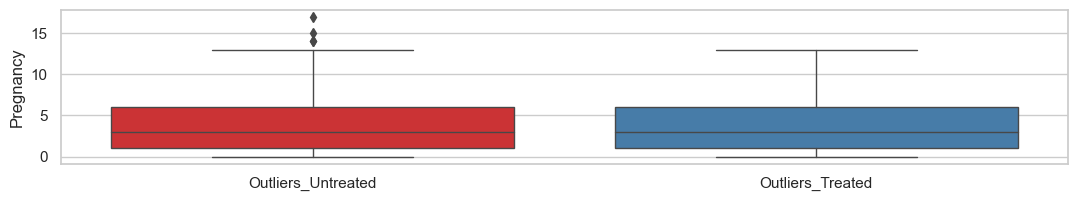

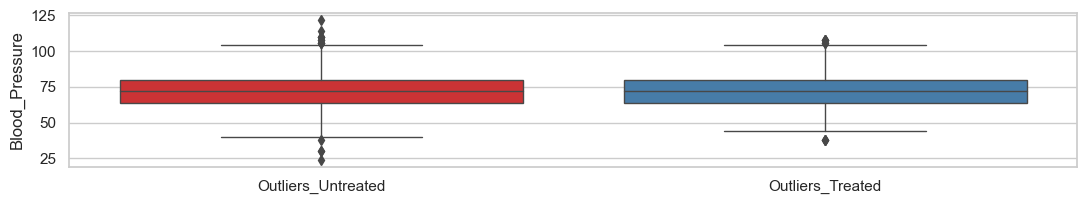

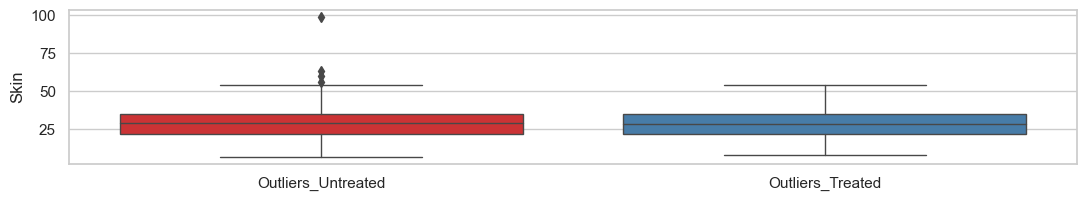

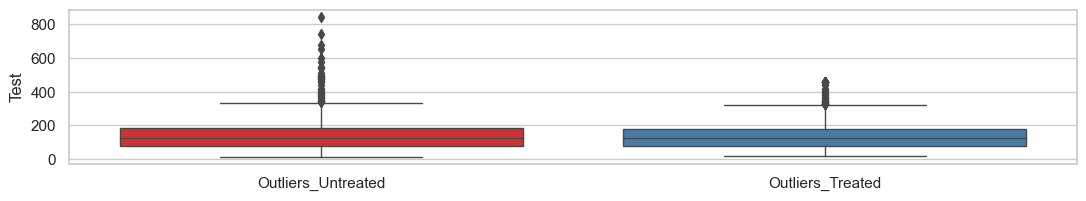

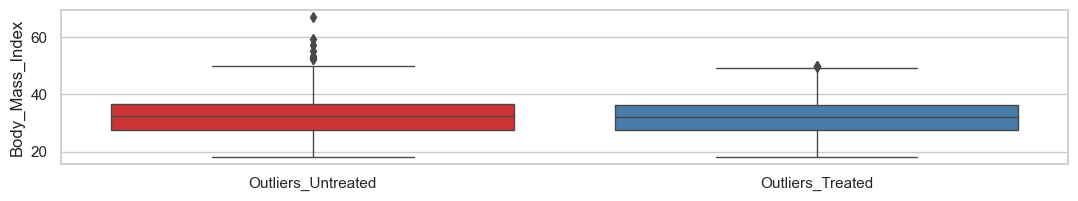

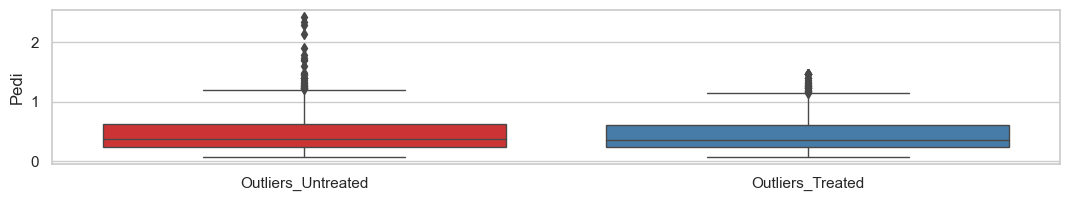

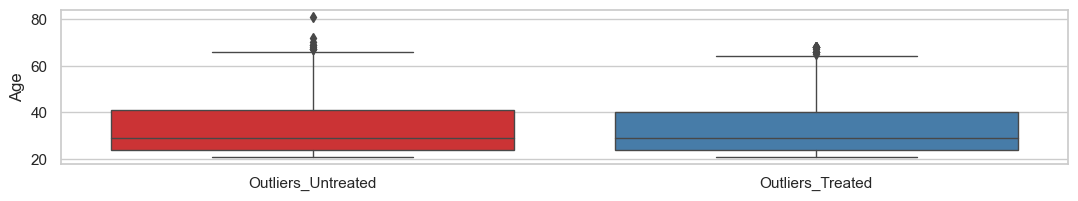

In [11]:
df_before = df_no_missing.copy()
df_before['condition']=['Outliers_Untreated']*df_before.shape[0]
df_after  = df_clean.copy()
df_after['condition'] =['Outliers_Treated']*df_after.shape[0]
df_before_after = pd.concat([df_before,df_after],axis=0)
df_before_after.head()

x   = 'condition'
for y in columns_with_outliers:
    df = df_before_after[ [x,y] ].copy().dropna().sort_values([x],ascending=[False]) 
    # BoxPlot
    sns.set(rc={'figure.figsize':(13,2)}); sns.set(style='whitegrid')
    sns_plot = sns.boxplot( x=x, y=y, data=df, linewidth=1.0, palette='Set1'); sns_plot.set_xlabel('')
    fig = sns_plot.get_figure(); plt.show()

#####   
<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:deeppink;"> Report: 
 - As expected, notable reduction in range and amount of outliers is achieved.

** **

#####   
<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> Observing Clean Variables

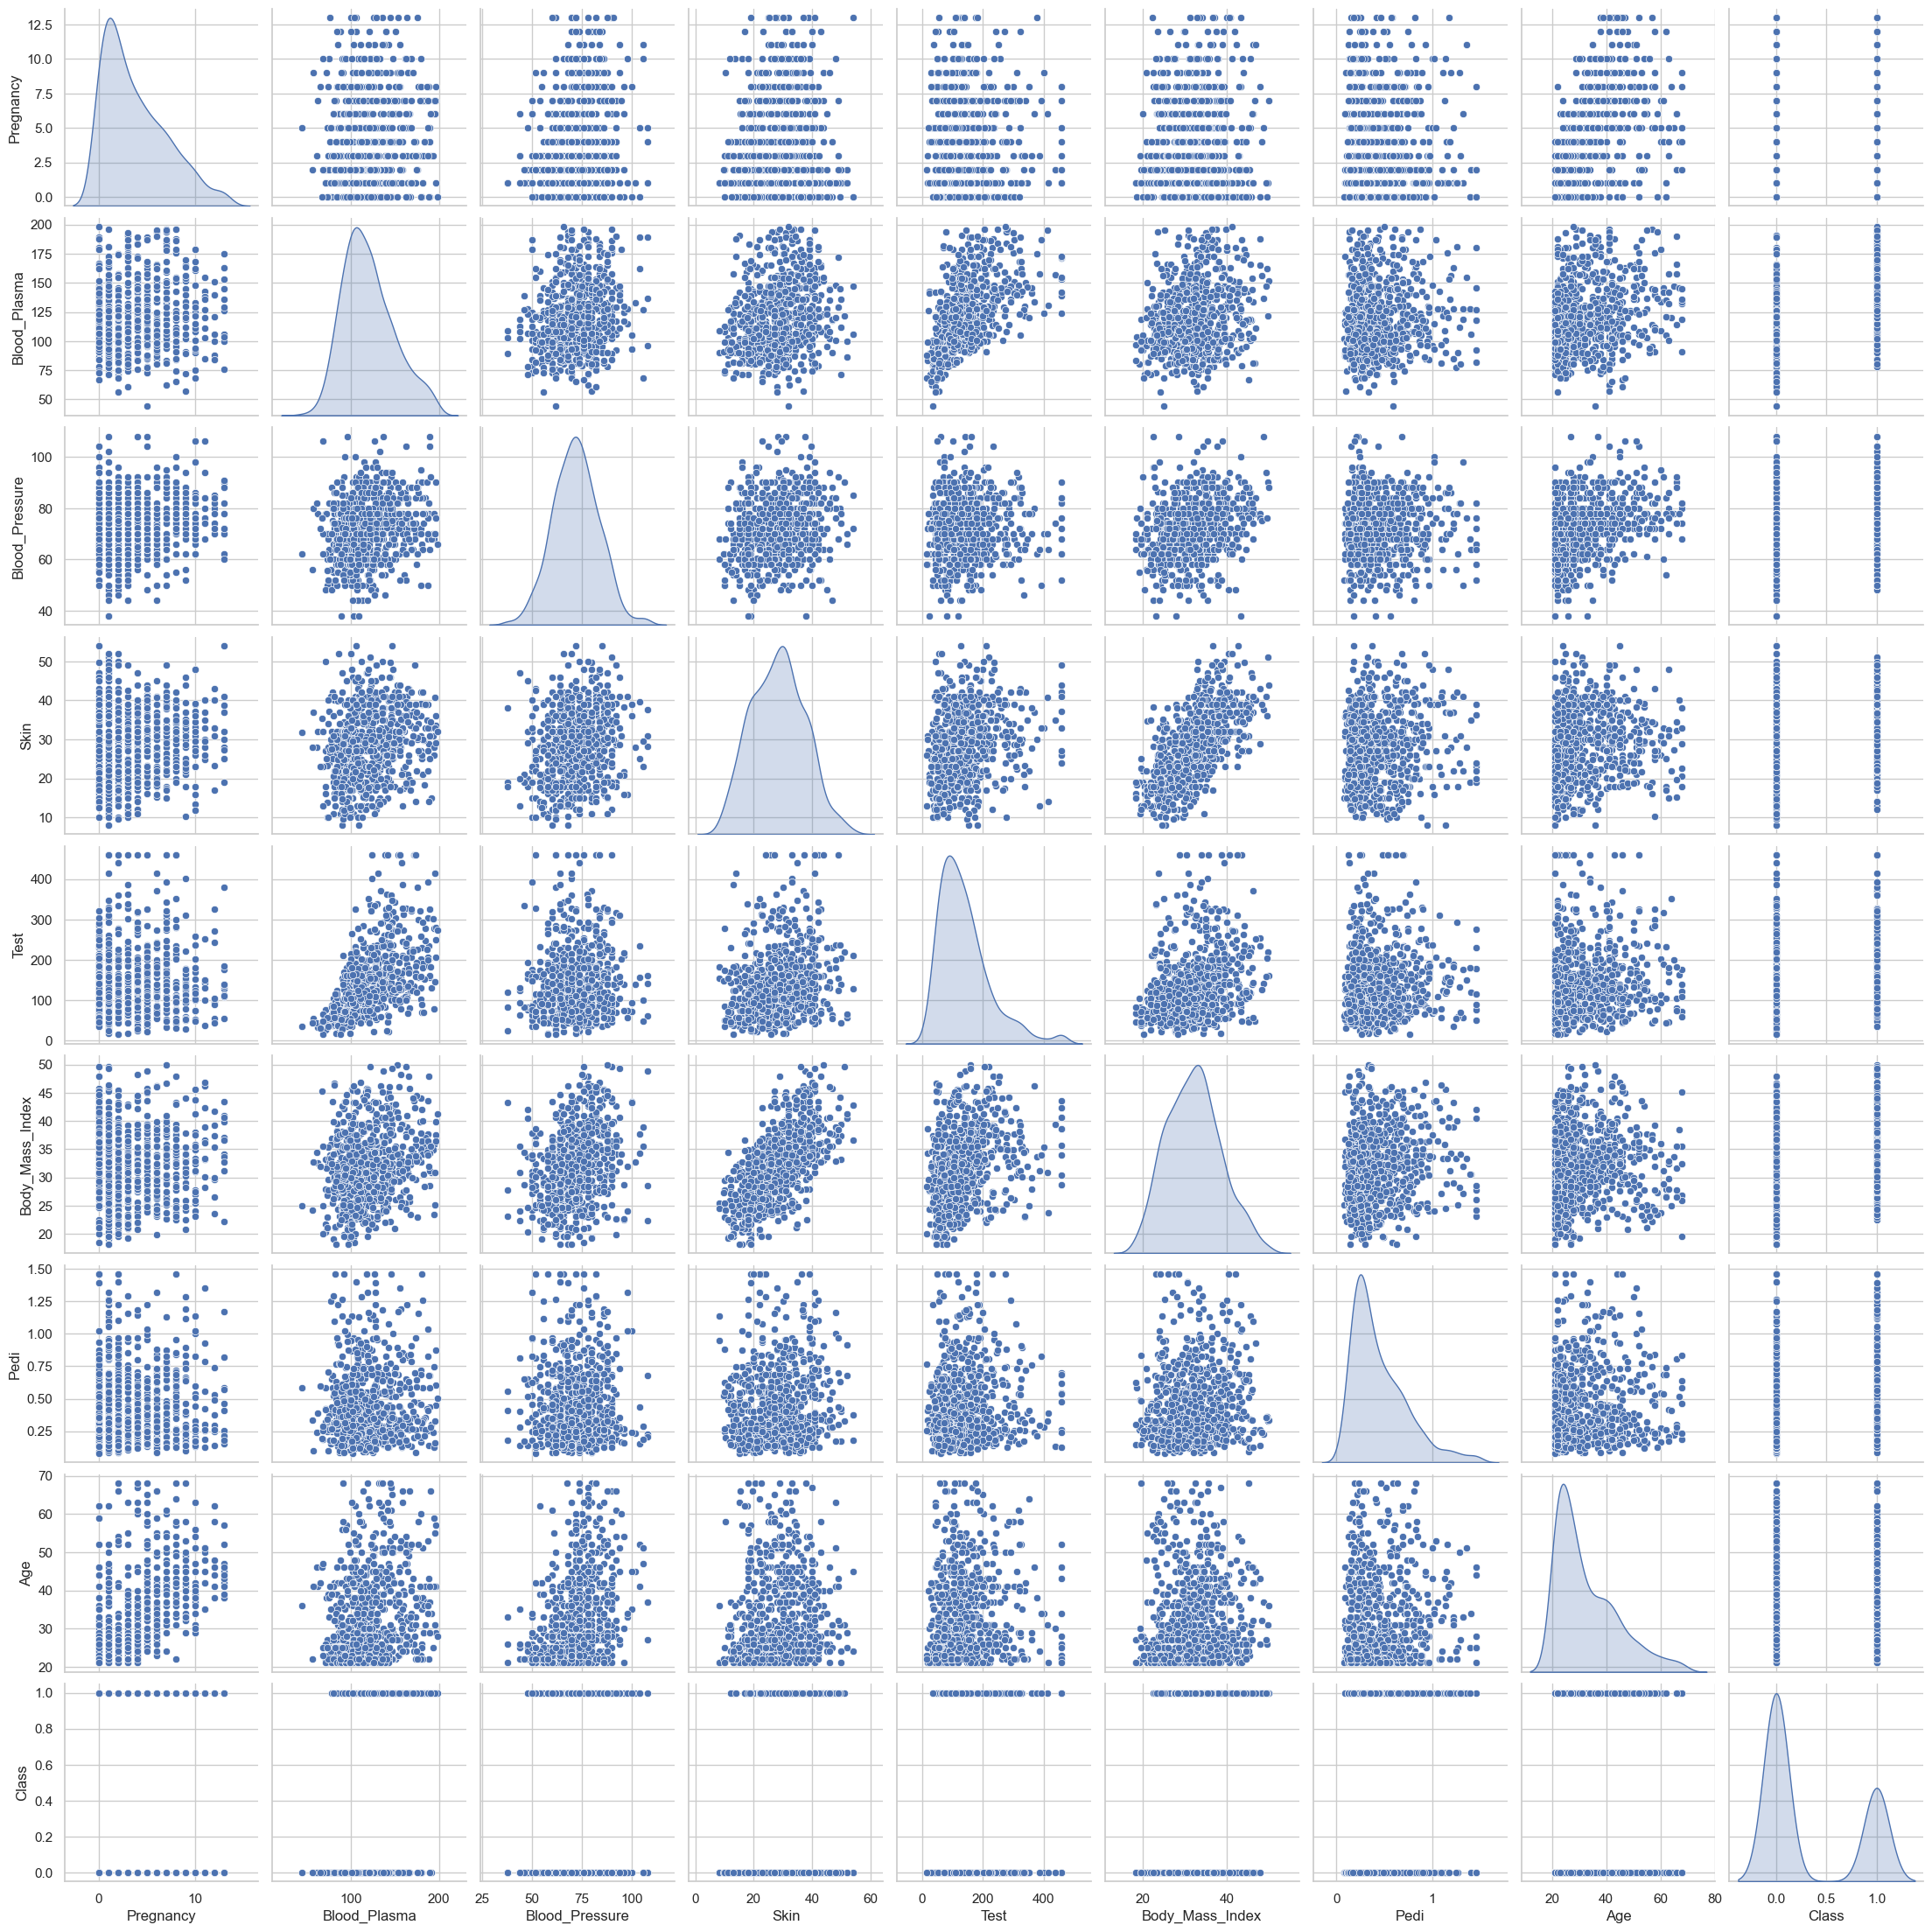

In [12]:
sns.pairplot( df_clean, diag_kind='kde' ); plt.show()

#####   
<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:deeppink;"> Report
    
 - Visually, The Pair-Plot Diagonal reveals that there are at least 2 gaussian distributions (clusters) in the data.

** **

#####   
<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> Saving Data Sets

In [13]:
from openpyxl       import Workbook
from openpyxl.utils import get_column_letter
from openpyxl       import load_workbook

wb = Workbook()
dest_filename = 'Cluster_DataSet.xlsx'
Empty = wb.active; Empty.title='Empty'     


XX = df_clean.values.copy()    
dfClean = wb.create_sheet('dfClean')
dfClean.append( list(df_clean.columns) )
for i in range( XX.shape[0] ): dfClean.append( list( XX[i,:] )  )

    
# Saving    
wb.save( filename = dest_filename )   

#####   
<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> Loading Data Sets

In [14]:
DataSet  = 'Cluster_DataSet.xlsx'
df_clean =  pd.read_excel( DataSet, 'dfClean'  , header=0 )

** **

#####   
<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> Scaling X

In [15]:
x_scaled = scale( df_clean )
x_scaled = x_scaled[:,:-1]

#####   
<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:deeppink;"> Report
    
 - As the last column, 'Class', is like a predefined cluster, it casts a heavy but heavenly shaddow on the clustering results. Unfortunately, in the real world problems, this manna does not exist. So, to make clustering more challenging, the 'Class' is not included in scaled x.

** **

#####   
<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> Finding optimum number of clusters by  Elbow Method
    
<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:#00b3e5;"> (Silhouette Score) & (Average Distortion)

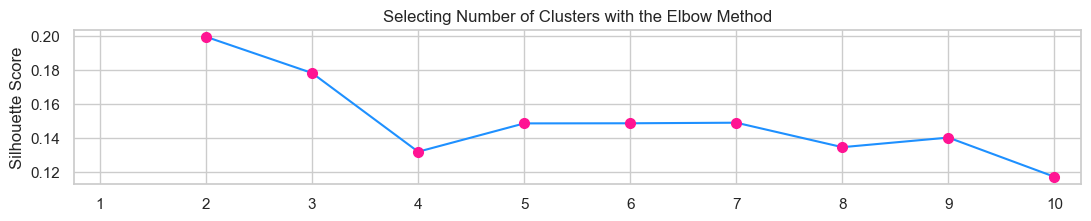

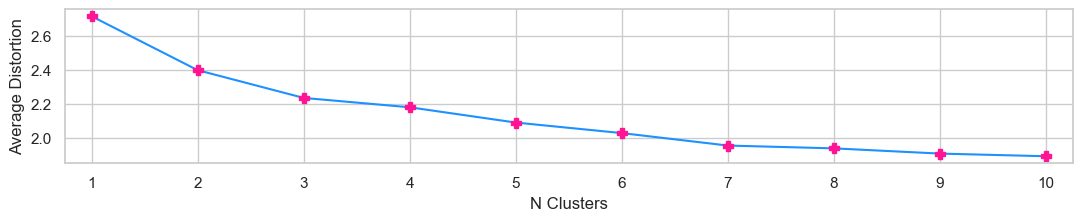

In [17]:
from scipy.spatial.distance import cdist

n_range = np.arange(1,11)

SILHOUETTE_SCORE, meanDistortions = [],[]
for n in n_range:
    #print('n =',n) 
    
    mbkmean = MiniBatchKMeans(
          n_clusters         =  n             #  int, default=8
        , n_init             =  500           # 'warn', 'auto' or int, default=10
        , init               = 'k-means++'    # 'k-means++', 'random'
        , tol                =  0.00001       #  float, default=1e-4
        , max_iter           =  10000         #   int,  default=300
        , verbose            =  0
        , random_state       =  RANDOM_STATE
        # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
        , compute_labels     =  True                         
        , init_size          =  None
        , batch_size         =  1024
        , max_no_improvement =  10
        , reassignment_ratio =  0.01
        )

    # fitting the clusterer
    clsr = mbkmean.fit( x_scaled )
    
    # silhouette score
    if n>1:
        clsr_ss = silhouette_score( x_scaled, clsr.labels_ )  # the smaller the better 
        SILHOUETTE_SCORE.append( clsr_ss )
        
    # mean distortions
    meanDistortions.append(sum(np.min(cdist( x_scaled, clsr.cluster_centers_, 'euclidean'), axis=1)) / x_scaled.shape[0])


# Plotting Silhouette Scores
plt.plot( n_range[1:], SILHOUETTE_SCORE, color='dodgerblue', marker='o', mec='deeppink', mfc='deeppink', markersize=7 ) 
plt.xticks(n_range)
plt.ylabel('Silhouette Score')
plt.xlim(0.75,10.25)
plt.title('Selecting Number of Clusters with the Elbow Method')
plt.show()   
    
# Plotting Mean Distortions
plt.plot( n_range, meanDistortions, color='dodgerblue', marker='P', mec='deeppink', mfc='deeppink', markersize=7 ) 
plt.xlabel('N Clusters')
plt.xticks(n_range)
plt.ylabel('Average Distortion')
plt.xlim(0.75,10.25)
plt.show()

#####   
<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:deeppink;"> Report
    
 - **Elbow Method** with **Silhouette Score** reveals that optimum number of clusters is Either **2** or **4**
 - **Elbow Method** with **Average Distortion** ensures that optimum number of clusters is **2**

<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:#00b3e5;"> Assigning

In [18]:
N_CLUSTERS = 2

** **

#####   
<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> Making (MiniBatch)kmeans Clusterer

In [20]:
mbkmean = MiniBatchKMeans( 
          n_clusters         =  2             #  int, default=8
        , n_init             =  500           # 'warn', 'auto' or int, default=10
        , init               = 'k-means++'    # 'k-means++', 'random'
        , tol                =  0.00001       #  float, default=1e-4
        , max_iter           =  10000         #   int,  default=300
        , verbose            =  0
        , random_state       =  RANDOM_STATE
        # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
        , compute_labels     =  True                         
        , init_size          =  None
        , batch_size         =  1024
        , max_no_improvement =  10
        , reassignment_ratio =  0.01
        )
clsr = mbkmean.fit( x_scaled ) 

#clsr_centroids = clsr.cluster_centers_    
#clsr_ss        = silhouette_score( x_scaled, clsr.labels_ )  # the smaller the better
#y_predict      = clsr.predict( x_scaled )    # new x
#y_distances    = clsr.transform( x_scaled )  # new x 

#####   
<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> PCA of Clusters

<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:#00b3e5;"> Initiating PCA

In [21]:
from sklearn.decomposition import PCA
pca = PCA( )
x_pca = pca.fit_transform( x_scaled )
x_pca_scaled = scale( 
    np.column_stack(( 
          x_pca[:,0]
        , x_pca[:,1] 
        )))

# pc1 pc2
x_pc1_scaled = x_pca_scaled[:,0] 
x_pc2_scaled = x_pca_scaled[:,1] 

<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:#00b3e5;"> PCA Scree Plot

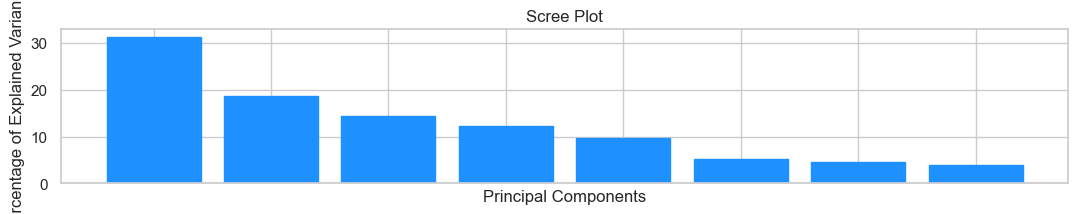

In [22]:
# Scree Plot
per_var = np.round( pca.explained_variance_ratio_ * 100, decimals=1 )
labels  = [ str(x) for x in range(1, len(per_var)+1) ]
   
plt.bar( 
          x         = range( 1, len(per_var)+1 )
        , height    = per_var
        , color     = 'dodgerblue'
        , edgecolor = 'dodgerblue'
        )
  
plt.tick_params( 
    axis='x',
    which='both',
    bottom=False,    
    top=False,
    labelbottom=False )
plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Principal Components')
plt.title('Scree Plot')
plt.savefig('Scree_Plot.png', dpi=120) 
plt.show()

<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:#00b3e5;"> PCA of Clusters Centroids

In [23]:
# Clusters Centroids
clsr_centroids = clsr.cluster_centers_

L = []
for i in range( clsr_centroids.shape[0] ):   L.append( list(clsr_centroids[i]) )
for i in range(       x_scaled.shape[0] ):   L.append( list(      x_scaled[i]) )

pca = PCA( )
L_pca = pca.fit_transform( L )
L_pca_scaled = scale( 
    np.column_stack(( 
          L_pca[:,0]
        , L_pca[:,1] 
        )))
# pc1 pc2
L_pc1_scaled = L_pca_scaled[:,0] 
L_pc2_scaled = L_pca_scaled[:,1] 

Centers_1 = L_pc1_scaled[ range(N_CLUSTERS) ]
Centers_2 = L_pc2_scaled[ range(N_CLUSTERS) ]
 

<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:#00b3e5;"> PCA Scatter Plot

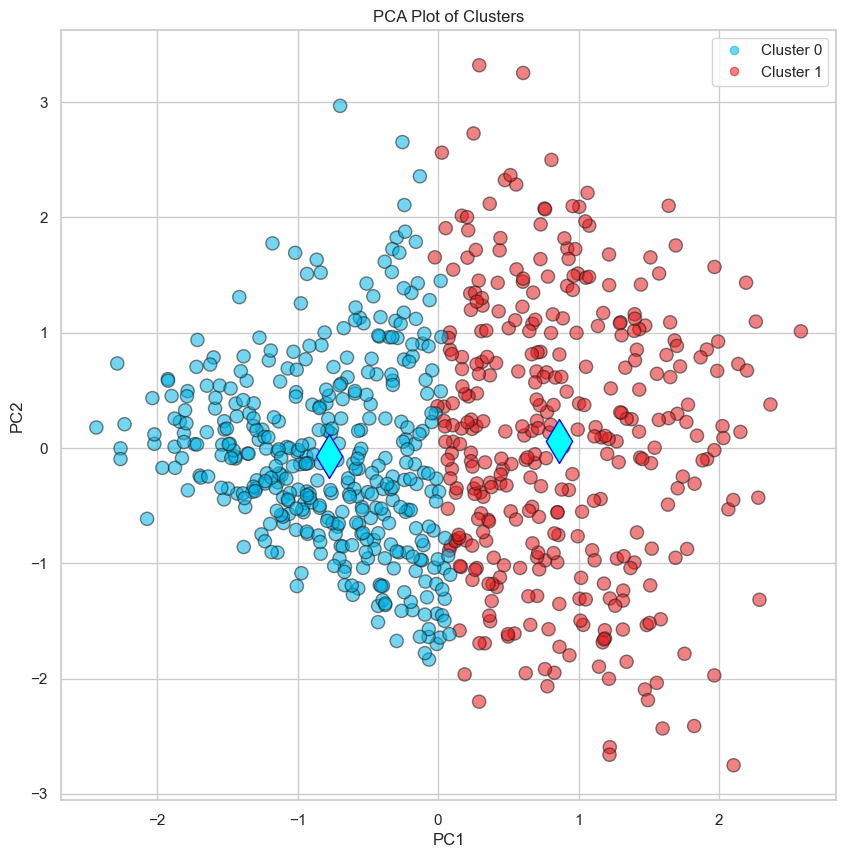

In [24]:
from matplotlib import colors

# Labels
y_predict = clsr.predict( x_scaled )

# Plot 
fig, ax = plt.subplots(figsize=(10,10)) # figsize=(10,10)  
 
# Labels
scatter1 = ax.scatter( 
      x_pc1_scaled
    , x_pc2_scaled  
    , cmap = colors.ListedColormap(['#00b3e5','#e41a1c'])    #  '#4daf4a'  cmap='rainbow_r'    
    , c    = y_predict
    , s    = 90
    , edgecolors = 'k'
    , alpha      = 0.55 
    )

# Centeroids
scatter2 = ax.scatter( 
      Centers_1
    , Centers_2
    , marker = 'd'
    , c      = 'cyan'
    , s      = 500
    , edgecolors = 'blue'
    , alpha      = 1.00 
    ) 

# Legend
legend = ax.legend( scatter1.legend_elements()[0],
                    scatter1.legend_elements()[1], 
                    loc='best')
legend.get_texts()[0].set_text('Cluster 0')
legend.get_texts()[1].set_text('Cluster 1')

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_title('PCA Plot of Clusters')

plt.savefig( 'pca1_pca2.png', dpi=180 )
plt.show()

** **

#####   
<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> Extracting Data From Clusters

<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:#00b3e5;"> DataFrame of Clusters

In [25]:
df_clusters            = df_clean.copy()
df_clusters['cluster'] = y_predict

<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:#00b3e5;"> Comparing Clusters

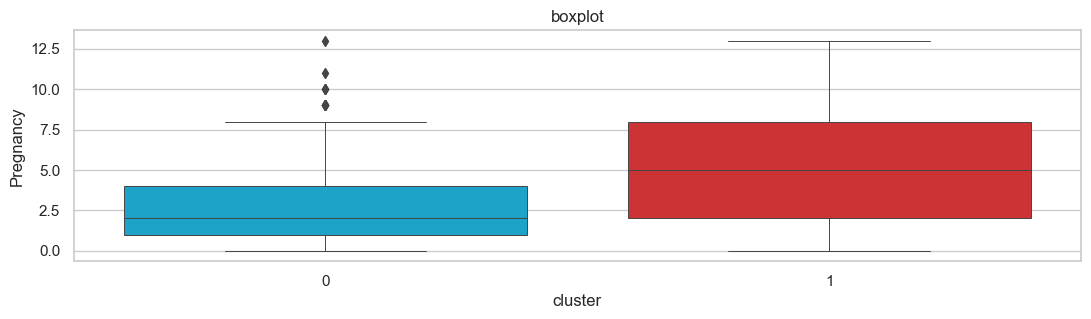

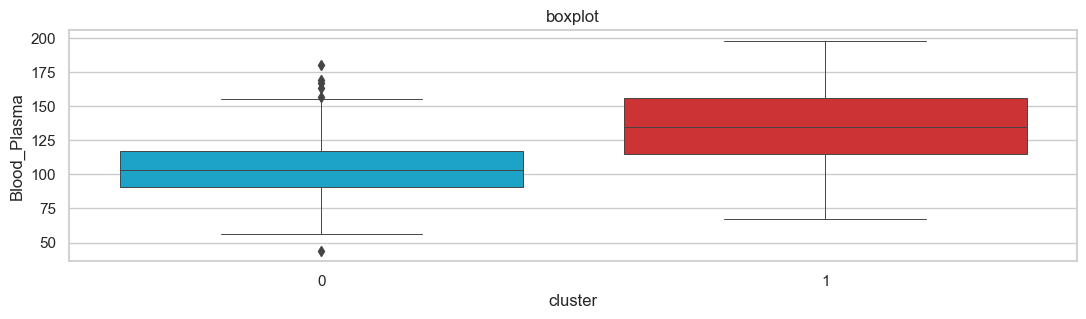

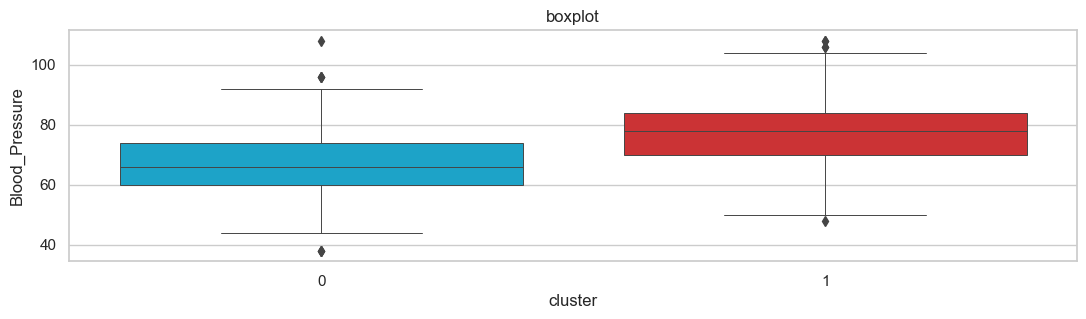

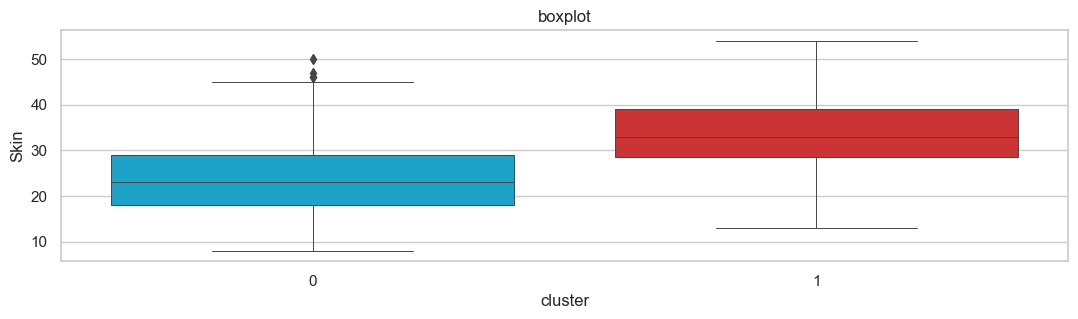

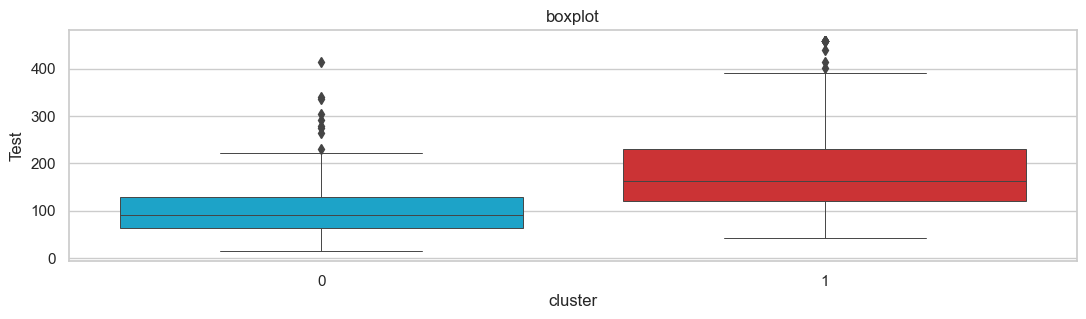

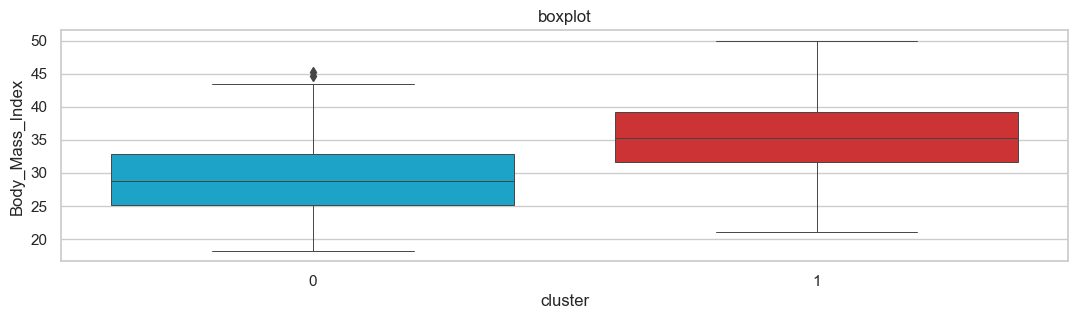

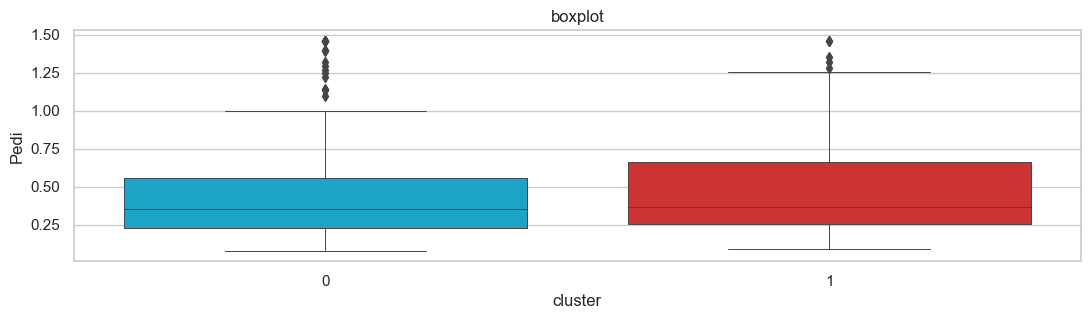

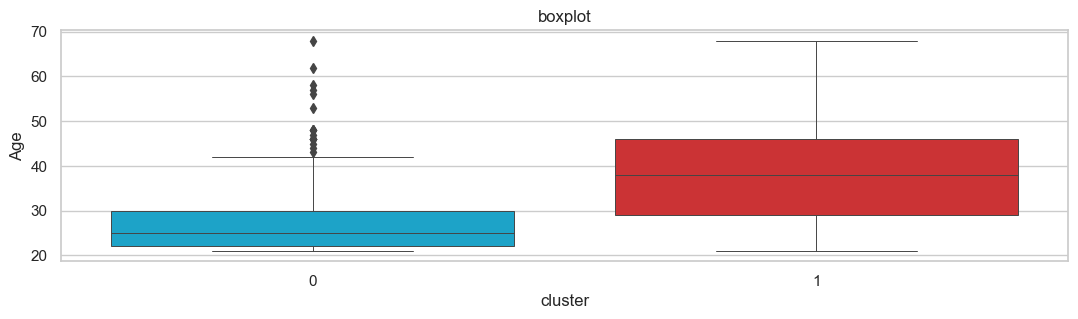

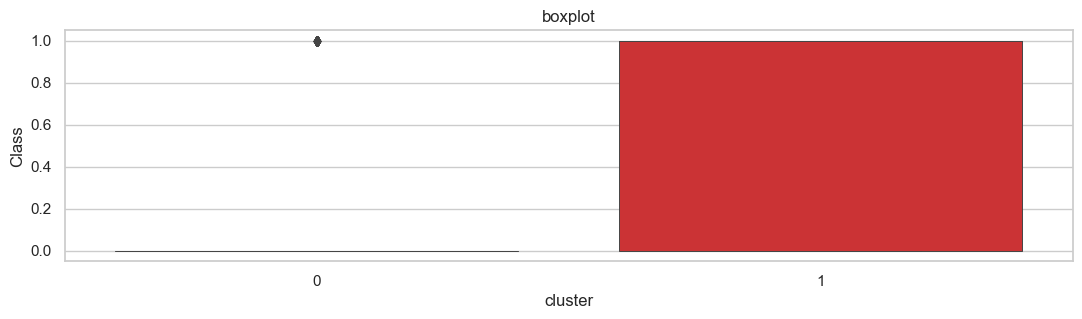

In [26]:
# boxplot 
sns.set(rc={'figure.figsize':(13,3)})
sns.set(style='whitegrid')

for ft in df_clean.columns: 
    sns_plot = sns.boxplot( x='cluster', y=ft, data=df_clusters, #hue='cluster',
                        #order=['frontal', 'parietal'],  # order of x 
                        linewidth=.7, 
                        palette=['#00b3e5','#e41a1c']    #  '#4daf4a'  
                          )  # Set1  Set2  Set3  rocket  vlag  blues_d  rainbow_r
    sns_plot.set( title="boxplot" )

    fig = sns_plot.get_figure() 
    #fig.savefig('boxplot.png')
 
    plt.show() 

#####   
<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:deeppink;"> Report
    
 - Data Visualization Reveals that, compared to cluster 0, members of cluster 1 have:
    - Higher Pregnancy Rate
    - Higher Blood Plasma
    - Higher Blood Pressure
    - Higher Skin Results
    - Higher Test Results
    - Higher Body Mass Index
    - Almost The Same Pedi
    - Higher Age Rate
****

 - So There is a significant difference between the clusters.
 - Members of Cluster 1 may need to put their health condition under closer scrutiny.

** **

#####   
<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> Out of Curiosity

We know the original dataset has a column **Class** which reflects 0 for healthy and 1 for diabetic person. to make clustering a challenge, we did not incude this column in clustering calculations, yet the clusterer can tell there are two groups: healthy and in-danger members. out of curiosity, we plot the PCA of 'Class' to see how close the 'Cluster Prediction' and the 'Class' are. 

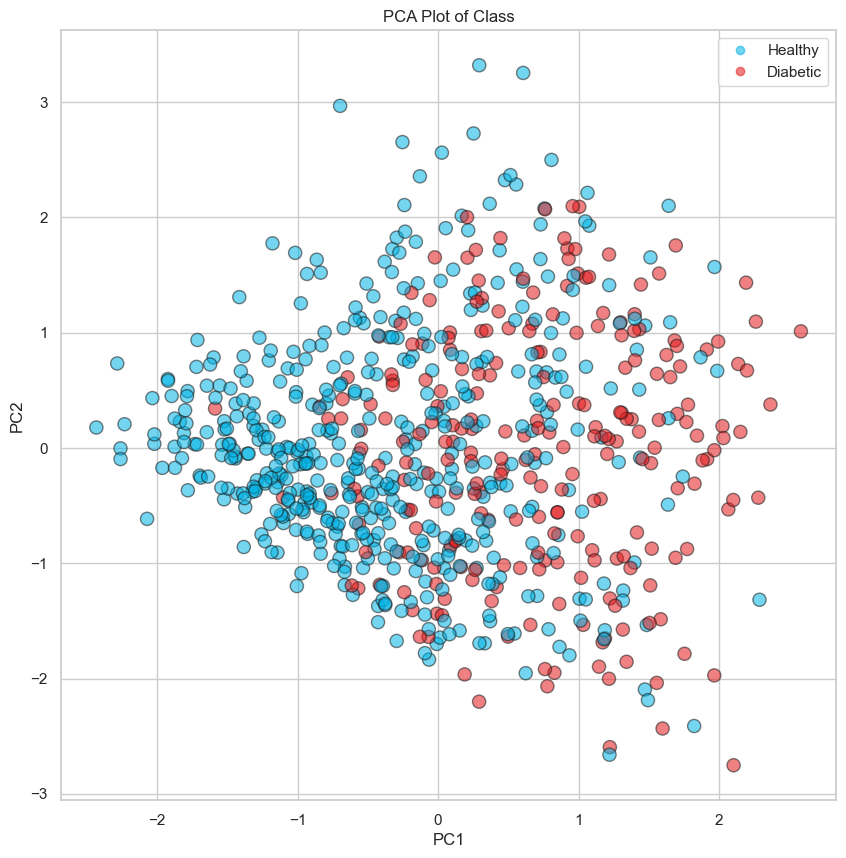

In [27]:
from matplotlib import colors

# Labels
y_predict = clsr.predict( x_scaled )

# Plot 
fig, ax = plt.subplots(figsize=(10,10)) # figsize=(10,10)  
 
# Labels
scatter1 = ax.scatter( 
      x_pc1_scaled
    , x_pc2_scaled  
    , cmap = colors.ListedColormap(['#00b3e5','#e41a1c'])    #  '#4daf4a'  cmap='rainbow_r'    
    , c    = df_clean['Class']
    , s    = 90
    , edgecolors = 'k'
    , alpha      = 0.55 
    ) 

# Legend
legend = ax.legend( scatter1.legend_elements()[0],
                    scatter1.legend_elements()[1], 
                    loc='best')
legend.get_texts()[0].set_text('Healthy')
legend.get_texts()[1].set_text('Diabetic')

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_title('PCA Plot of Class')

plt.savefig( 'pca1_pca2.png', dpi=180 )
plt.show()

#####   
<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:deeppink;"> Report
    
 - **Cluster Labels** and **Class Labels** are **not identical**, but amazingly **analogous**

** **

#####   
<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> Saving Estimators To Disk

In [28]:
ESTIMATORS       = [      clsr       ]
ESTIMATORS_Names = [ 'mbkmeans_clsr' ]

for i in range( len(ESTIMATORS) ):
    Estimator        = ESTIMATORS[ i ]
    Destination_File = ESTIMATORS_Names[ i ]+'.sav'
    pickle.dump( Estimator, open(Destination_File,'wb') )

#####   
<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> Loading Estimators From Disk

In [29]:
clsr  =  pickle.load( open( 'mbkmeans_clsr.sav'  ,'rb') )

** **

#####   
<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> Making The Final Estimator

<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:#00b3e5;"> Checkig Range of Features

In [30]:
round( df_clean.describe().T[['min','max']], 3 )

,min,max
Pregnancy,0.000,13.000
Blood_Plasma,44.000,198.000
Blood_Pressure,38.000,108.000
Skin,8.000,54.000
Test,15.000,459.165
Body_Mass_Index,18.200,50.000
Pedi,0.078,1.461
Age,21.000,68.000
Class,0.000,1.000


<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:#00b3e5;"> Entering A New Item

In [31]:
# input data                R  a  n  g  e  

Pregnancy       =   1.0     #  0.0   13.0
Blood_Plasma    =  89.0     # 56.0  198.0
Blood_Pressure  =  66.0     # 38.0  108.0
Skin            =  23.0     #  8.0   54.0
Test            =  94.0     # 15.0  459.2
Body_Mass_Index =  28.0     # 18.2   52.9
Pedi            =   0.2     # 0.078  1.461
Age             =  21.0     # 21.0   68.0
Class           =   0.0     #  0.0    1.0    

<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:#00b3e5;"> Predicting 

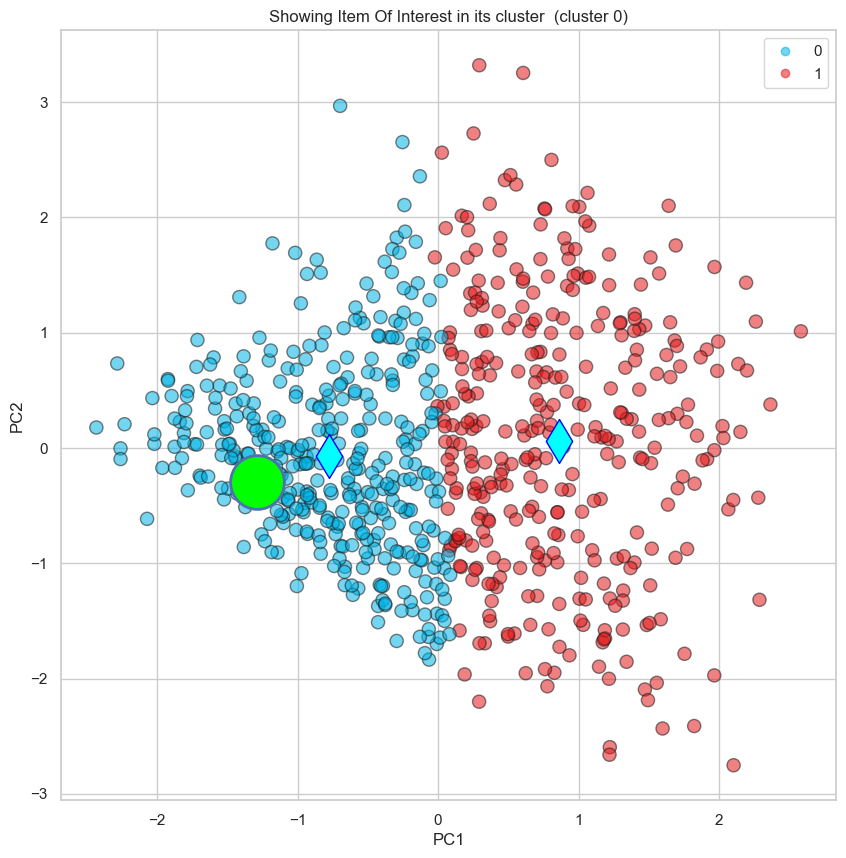

In [33]:
# x 
x = df_clean.iloc[:,:-1].copy()

# s  written in the same order as  x
s = [ Pregnancy, Blood_Plasma, Blood_Pressure, Skin, Test, Body_Mass_Index, Pedi, Age ]

encode_columns = [] 
def predicted_class( s, x, encode_columns ):
    s  = pd.DataFrame( [s.copy(),s.copy()], columns=x.columns )
    sx = pd.concat( [s,x], axis=0 )
    sx_encoded = pd.get_dummies(
          sx
        , columns = encode_columns
        )
    #print(sx_encoded.columns)
    sx_scaled = scale(  sx_encoded.iloc[1:,:]  )  
    
    pca   = PCA( )
    sx_pca = pca.fit_transform( sx_scaled )
    sx_pca_scaled = scale( 
    np.column_stack(( 
          sx_pca[:,0]
        , sx_pca[:,1] 
        )))
    # pc1 pc2
    sx_pc1_scaled = sx_pca_scaled[:,0] 
    sx_pc2_scaled = sx_pca_scaled[:,1] 
    
    s1 = sx_pc1_scaled[ 0 ]
    s2 = sx_pc2_scaled[ 0 ]
    
    sx_scaled = sx_scaled[[0,1]]      
    pred = clsr.predict( sx_scaled )[0]  
    
    return pred, s1,s2 


# Predicting
pred, s1, s2 = predicted_class( s, x, encode_columns )
    
# PCA Scatter Plot 
fig, ax = plt.subplots(figsize=(10,10)) # figsize=(10,10)  
#cmap = colors.ListedColormap(['#e41a1c','#4daf4a']) 

scatter1 = ax.scatter( 
      x_pc1_scaled
    , x_pc2_scaled
    , cmap = colors.ListedColormap(['#00b3e5','#e41a1c'])    #  '#4daf4a'  cmap='rainbow_r'  
    , c    = y_predict
    , s    = 90
    , edgecolors = 'k'
    , alpha      = 0.55 
    )

scatter2 = ax.scatter( 
      Centers_1
    , Centers_2
    , marker = 'd'
    , c      = 'cyan'
    , s      = 500
    , edgecolors = 'blue'
    , alpha      = 1.00 
    )

scatter3 = ax.scatter( 
      s1
    , s2
    , marker = 'o'
    , c      = 'lime'
    , s      = 1500
    , edgecolors = 'b'
    , linewidths =  2
    , alpha      =  1.00 
    ) 

legend = ax.legend( scatter1.legend_elements()[0],
                    scatter1.legend_elements()[1], 
                    loc='best')
    
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_title('Showing Item Of Interest in its cluster  (cluster '+str(pred)+')') 

plt.savefig('pca1_pca2.png', dpi=180 )
plt.show()

#####   

#####   